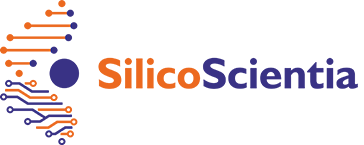




---


# **High-Throughput Virtual Screening with Machine Learning**

Welcome to this advanced tutorial on high-throughput virtual screening (HTVS). This workflow demonstrates a powerful, multi-stage funnel approach to efficiently screen large chemical libraries and identify promising drug candidates. By integrating machine learning for initial hit identification and ADMET filtering for drug-likeness, we can significantly accelerate the drug discovery process.

**In this tutorial, you will learn how to:**

1. Set up the environment and install all necessary dependencies.
2. Train a machine learning model to predict compound activity.
3. Screen a new chemical library to identify potential "hits."
4. Predict and filter compounds based on their ADMET (Absorption, Distribution, Metabolism, Excretion, Toxicity) properties.
5. Prepare the final candidates for molecular docking.
6. Perform and analyze docking simulations to predict binding affinity and pose.
7. Analyze detailed protein-ligand interactions for the top candidates.

This notebook is designed to guide you through a complete, real-world screening cascade, from a large library to a few high-quality candidates.

**Download the example data from the GitHub link**: https://github.com/SilicoScientia/Workshop_Screening



---


# **Setting Up the Environment and Dependencies**
Before we begin, we need to set up our computational environment. This initial step will:
1. Clone the project repository from GitHub to access the necessary datasets.
2. Install all required Python packages for cheminformatics, machine learning, and data handling.

**Why is this important?**

* Cloning the repository ensures we have all the necessary data files (Screening_training_data.csv, Prediction_data.csv, etc.).
* The Python packages (rdkit, admet-ai, openbabel-wheel, etc.) provide the core functionality for molecular manipulation, model training, and analysis used throughout this workflow.

*Note: The installation process may take a few minutes to complete.*

In [1]:
# @title
# Clone your repo and install dependencies
!git clone https://github.com/SilicoScientia/Workshop_Screening.git
!pip install rdkit admet-ai openbabel-wheel matplotlib

Cloning into 'Workshop_Screening'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 34 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 166.86 KiB | 459.00 KiB/s, done.
Resolving deltas: 100% (7/7), done.




---


# **Training the Activity Prediction Model**
In this section, we will build and train a machine learning model to classify compounds as "active" or "1" and "inactive" or "0". This serves as the first filter in our screening funnel. The process involves:
1. Loading a pre-labeled training dataset (Screening_training_data.csv).
2. Converting molecular structures (SMILES) into numerical features (Morgan fingerprints) that the model can understand.
3. Splitting the data into training and testing sets to ensure robust evaluation.
4. Training a Random Forest Classifier on the training data.
5. Evaluating the model's performance on the unseen test set.
6. Saving the trained model (rf_model.pkl) for use in the next step.

**Why use a Machine Learning Classifier?**
* A trained classifier can rapidly screen millions of compounds to predict their activity, which is far more efficient than experimental testing or even docking every single molecule.
* This allows us to quickly narrow down a vast chemical library to a smaller, more manageable set of potential hits.

*Tip: The classification report printed at the end shows key performance metrics like precision and recall. A good model will have high values for both, indicating it is both accurate and reliable.*

In [2]:
# @title
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Load training data
df = pd.read_csv('Workshop_Screening/Screening_training_data.csv')

# Featurize SMILES to Morgan fingerprints
def smiles_to_morgan(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return None

fps = [smiles_to_morgan(s) for s in df['Smiles']]
valid_idx = [i for i, fp in enumerate(fps) if fp is not None]
fps = [fp for fp in fps if fp is not None]
X = [list(fp) for fp in fps]
y = df.loc[valid_idx, 'Label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(clf, 'rf_model.pkl')

[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerator
[15:57:22] DEPRECATION WARNING: please use MorganGenerat

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       338
           1       0.93      0.96      0.94       382

    accuracy                           0.94       720
   macro avg       0.94      0.94      0.94       720
weighted avg       0.94      0.94      0.94       720



['rf_model.pkl']



---


# **Screening New Compounds with the Trained Model**
Now that we have a trained model, we can use it to perform virtual screening on a new, unlabeled dataset of compounds. This step involves:
1. Loading our saved Random Forest model (rf_model.pkl).
2. Loading the new dataset of compounds to be screened (Prediction_data.csv).
3. Featurizing the new molecules into the same Morgan fingerprint format used during training.
4. Using the model to predict the activity label (1 for active, 0 for inactive) for each compound.
5. Saving the results, including the SMILES, ligand name, and predicted label, to a new file (predicted_labels.csv).

**Why is this important?**
* This is the core of our high-throughput screening process. The model acts as a rapid and cost-effective filter, identifying a small subset of potentially active compounds from a large library.
* By automating this prediction, we can process thousands or even millions of molecules in a fraction of the time it would take for experimental screening.

*Note: The output file predicted_labels.csv will be used in the next step to filter for only the predicted "active" compounds.*

In [3]:
# @title
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import joblib

# Load trained model
clf = joblib.load('rf_model.pkl')

# Load prediction data from repo
df_pred = pd.read_csv('Workshop_Screening/Prediction_data.csv')

# Featurize SMILES
def smiles_to_morgan(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return None

fps = [smiles_to_morgan(s) for s in df_pred['Smiles']]
valid_idx = [i for i, fp in enumerate(fps) if fp is not None]
valid_smiles = df_pred.loc[valid_idx, 'Smiles'].reset_index(drop=True)
ligand_names = df_pred.loc[valid_idx, 'Ligand'].reset_index(drop=True) if 'Ligand' in df_pred.columns else valid_smiles
fps = [fp for fp in fps if fp is not None]
X = [list(fp) for fp in fps]

# Predict
y_pred = clf.predict(X)

# Save predictions
output_df = pd.DataFrame({
    'smiles': valid_smiles,
    'ligand': ligand_names,
    'Label': y_pred.astype(int)
})
output_df.to_csv('predicted_labels.csv', index=False)
print("Prediction complete. Output saved to 'predicted_labels.csv'.")

[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerat

Prediction complete. Output saved to 'predicted_labels.csv'.




---

# **Filtering for Predicted Active Compounds**
With the predictions from our machine learning model, the next logical step is to isolate the compounds that have been identified as potential "hits." This simple but crucial step involves:
1. Loading the prediction results from predicted_labels.csv.
2. Filtering the dataset to keep only the compounds with a predicted Label of 1 (active).
3. Saving this smaller, more focused list of compounds to a new file, filtered_compounds.csv.

**Why is this important?**
* This step officially concludes the first stage of our screening funnel. We have successfully reduced a large, unmanageable library to a small, high-potential subset.
* The resulting filtered_compounds.csv file contains only our top candidates, which will now proceed to the next stage of evaluation: ADMET analysis.

*Tip: Pay attention to the number of compounds that pass this filter. This gives you a clear idea of the model's hit rate and the size of the candidate pool for downstream analysis.*

In [4]:
# @title
# Load predictions
df = pd.read_csv('predicted_labels.csv')

# Filter actives
filtered = df[df['Label'] == 1].copy()
filtered.to_csv('filtered_compounds.csv', index=False)
print(f"Filtered {len(filtered)} active compounds for ADMET analysis.")

Filtered 2189 active compounds for ADMET analysis.




---

# **ADMET Property Prediction for Filtered Hits**
Now that we have a list of potentially active compounds, we need to evaluate their drug-likeness. A compound that is highly active but has poor pharmacokinetic properties (e.g., it's toxic or can't be absorbed by the body) is unlikely to become a successful drug. In this section, we will:
1. Load our filtered list of active compounds from filtered_compounds.csv.
2. Use the ADMET-AI model to predict a wide range of ADMET (Absorption, Distribution, Metabolism, Excretion, and Toxicity) properties for each compound.
3. Organize these predictions into a comprehensive table.
4. Save the detailed ADMET results to admet_results.csv for further filtering.

**Why use ADMET-AI?**
* ADMET-AI provides a fast, in-silico method to assess the drug-like potential of our hits. This is the second critical filter in our cascade.
* By identifying compounds with potential liabilities (like toxicity or poor bioavailability) early on, we can avoid wasting time and resources on candidates that are likely to fail in later stages of drug development.

*Note: The patch_torch_load function is a technical workaround required to ensure compatibility between the ADMET-AI model and the current version of PyTorch in this environment.*

In [5]:
# @title
import pandas as pd
from admet_ai import ADMETModel
import torch
from functools import wraps
import os

def patch_torch_load():
    original_load = torch.load
    @wraps(original_load)
    def patched_load(f, *args, **kwargs):
        if isinstance(f, str) and ('admet_ai' in f or 'chemprop' in f):
            kwargs['weights_only'] = False
        return original_load(f, *args, **kwargs)
    torch.load = patched_load

# Read filtered compounds
compounds_df = pd.read_csv('filtered_compounds.csv')
smiles_list = compounds_df['smiles'].tolist()
ligand_names = compounds_df['ligand'].tolist()

print(f"Running ADMET analysis on {len(smiles_list)} compounds...")

patch_torch_load()
model = ADMETModel()
predictions = model.predict(smiles_list)

results_df = pd.DataFrame(predictions)
results_df['SMILES'] = smiles_list
results_df['ligand'] = ligand_names

results_df.to_csv('admet_results.csv', index=False)
print("ADMET analysis results saved to 'admet_results.csv'")

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


Running ADMET analysis on 2189 compounds...
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight

ividual models:   0%|                                                                                  | 0/5 [00:00<?, ?it/s]

                                                                                                   | 0/44 [00:00<?, ?it/s]

█                                                                                          | 1/44 [00:00<00:06,  6.80it/s]

███▏                                                                                       | 2/44 [00:00<00:05,  7.03it/s]

█████▎                                                                                     | 3/44 [00:00<00:09,  4.29it/s]

███████▎                                                                                   | 4/44 [00:00<00:07,  5.24it/s]

█████████▍                                                                                 | 5/44 [00:00<00:06,  5.98it/s]

███████████▌                                                                               | 6/44 [00:01<00:05,  6.51it/s]

█████

ADMET analysis results saved to 'admet_results.csv'




---


# **Filtering Compounds Based on ADMET Properties**
This section applies the final filter in our pre-docking screening cascade. We will use the detailed ADMET predictions to select only the compounds with the most promising drug-like profiles. This interactive step involves:
1. Loading the ADMET prediction results from admet_results.csv.
2. Allowing the user to define acceptable thresholds for various properties (e.g., molecular weight, LogP, toxicity).
3. Filtering the compounds based on these user-defined criteria.
4. Saving the final, highly-curated list of candidates to filtered_admet_results.csv.
5. Visualizing the 2D structures of the final compounds along with their key properties for a clear, final review.

**Why is this important?**
* This step refines our candidate list by enforcing established rules for drug-likeness, such as Lipinski's Rule of Five.
* It ensures that the compounds proceeding to the computationally expensive docking stage are not only predicted to be active but also have a high probability of possessing favorable pharmacokinetic properties.
* The visualization provides a quick, intuitive summary of the final candidates before they move on to the next phase of analysis.

*Tip: You can rerun this cell with different thresholds to explore how filtering criteria affect the final selection of compounds.*


Total compounds in ADMET results: 2189

ADMET Property Thresholds Configuration
Enter new values for each property (press Enter to keep default value)



molecular_weight (default: 300 <):  

logP (default: 5.0 <):  

hydrogen_bond_acceptors (default: 10 <):  

hydrogen_bond_donors (default: 5 <):  

tpsa (default: 90 <):  

Lipinski (default: 0.5 >):  

QED (default: 0.75 >):  

Bioavailability_Ma (default: 0.75 >):  

hERG (default: 0.15 <):  

AMES (default: 0.25 <):  


After filtering molecular_weight < 300: 475 compounds remaining
After filtering logP < 5.0: 455 compounds remaining
After filtering hydrogen_bond_acceptors < 10: 455 compounds remaining
After filtering hydrogen_bond_donors < 5: 441 compounds remaining
After filtering tpsa < 90: 410 compounds remaining
After filtering Lipinski > 0.5: 410 compounds remaining
After filtering QED > 0.75: 89 compounds remaining
After filtering Bioavailability_Ma > 0.75: 62 compounds remaining
After filtering hERG < 0.15: 27 compounds remaining
After filtering AMES < 0.25: 19 compounds remaining

Filtered results saved to filtered_admet_results.csv

Summary of filtered compounds:
Total compounds: 19

Mean values for key properties:
molecular_weight: 231.29
logP: 2.28
hydrogen_bond_acceptors: 2.89
hydrogen_bond_donors: 1.37
tpsa: 56.47
Lipinski: 4.00
QED: 0.79
Bioavailability_Ma: 0.88
hERG: 0.05
AMES: 0.10

Filtered SMILES saved to filtered_admet_smiles.smi

Generating 2D structure visualization...

2D struct

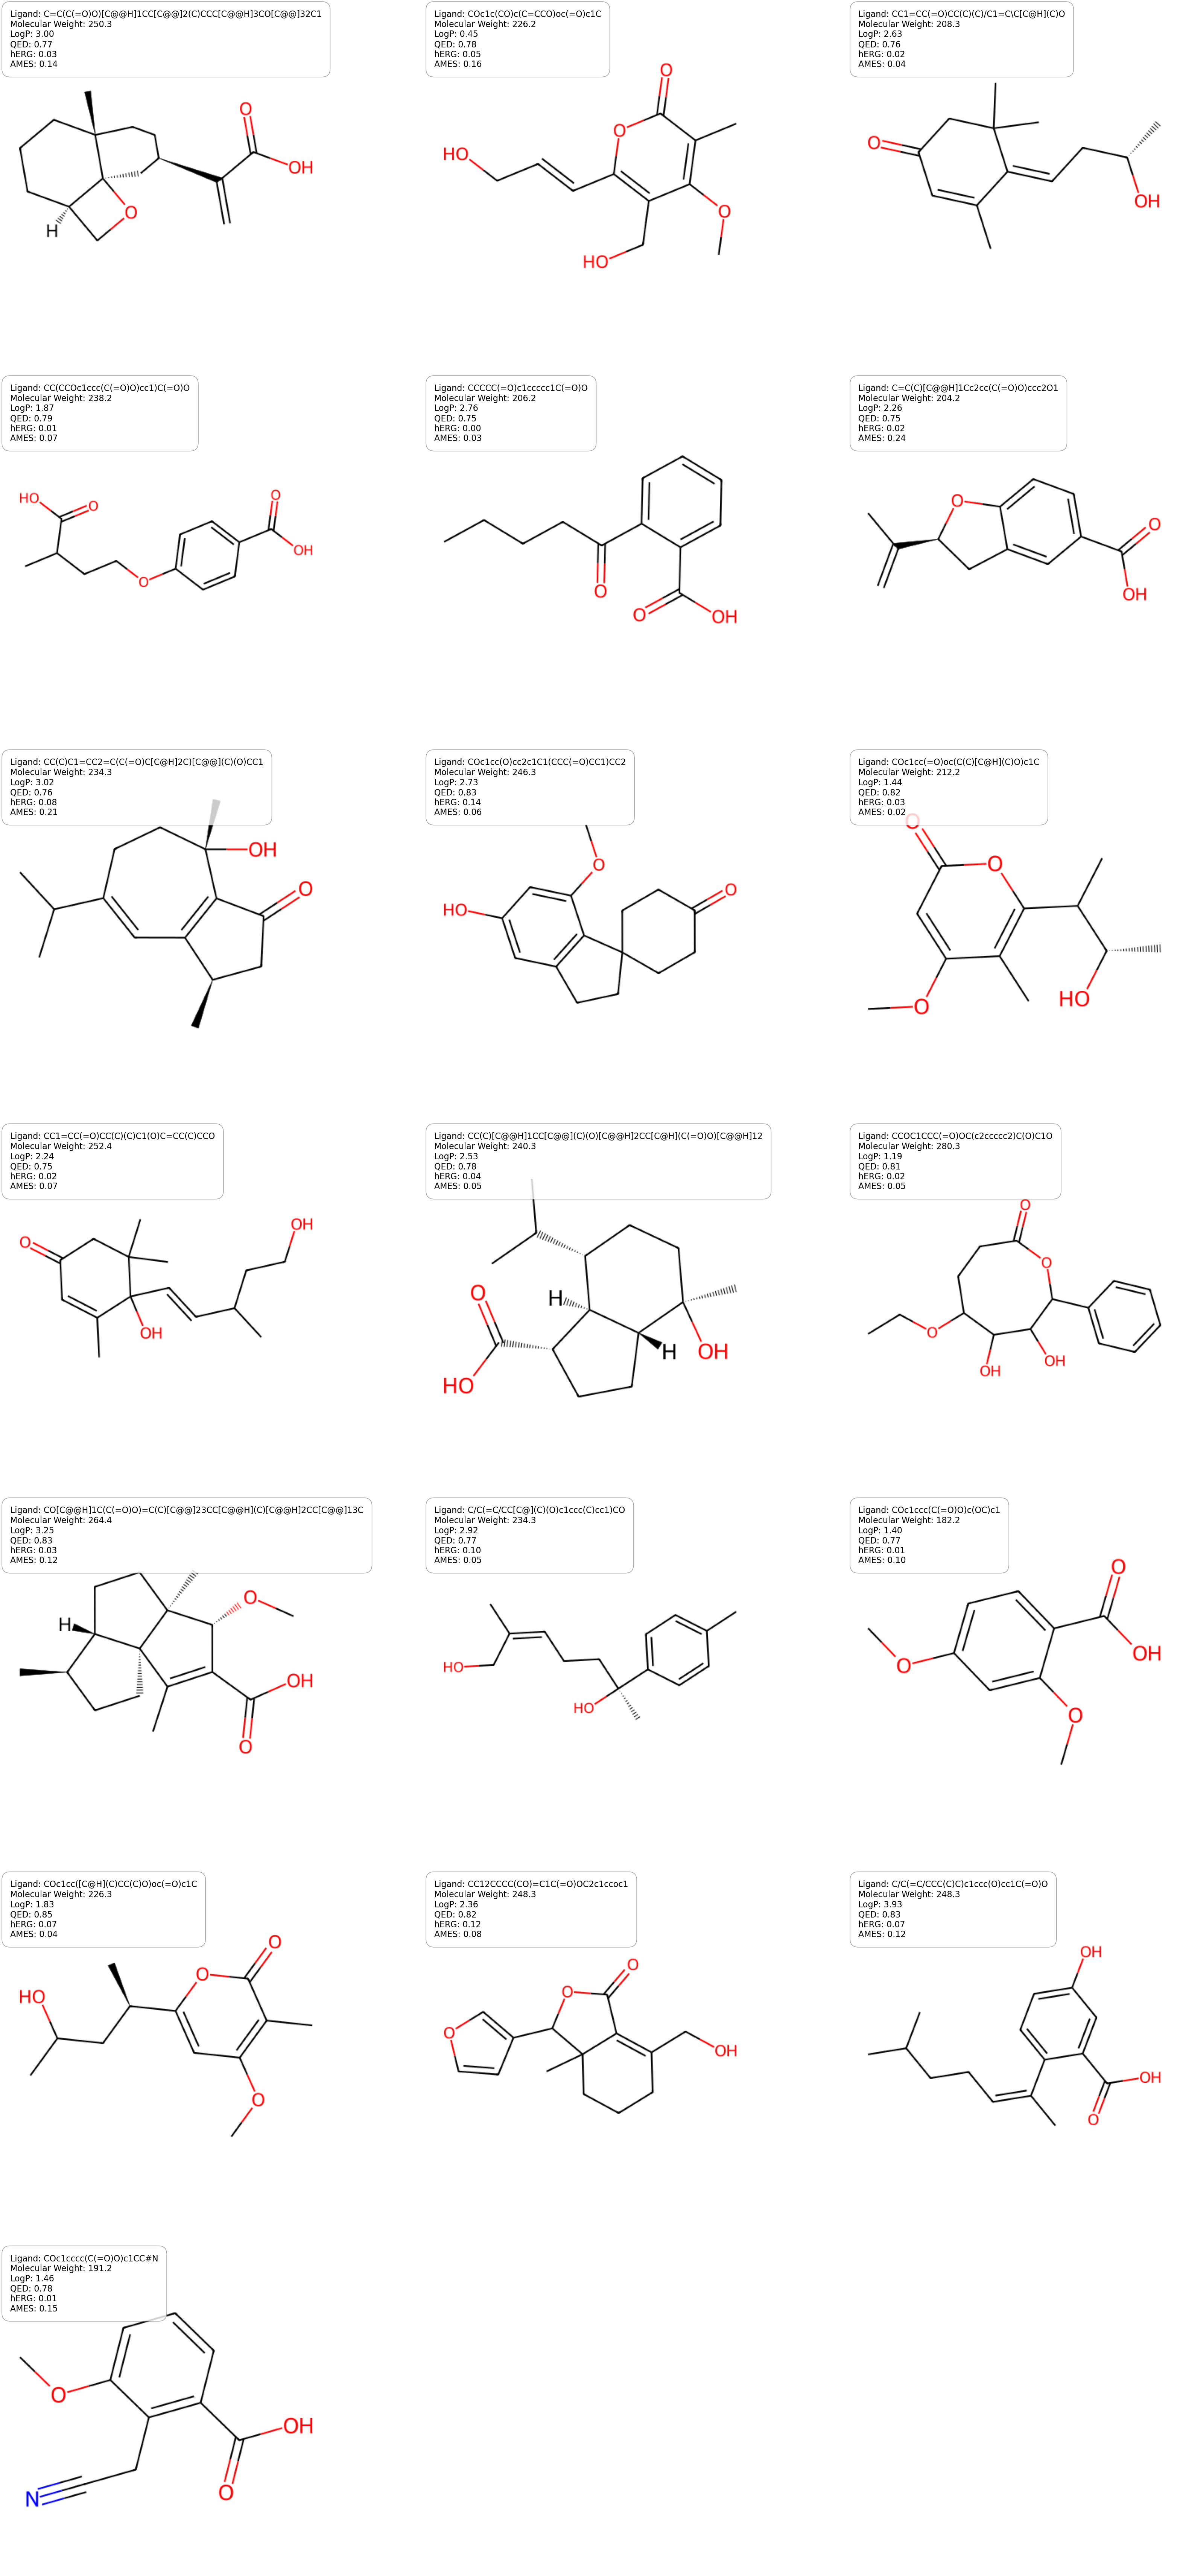

In [6]:

# @title
import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def visualize_compounds(df, output_file='filtered_compounds_2D.png'):
    """
    Visualize 2D structures of compounds with their properties

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing compounds and their properties
    output_file : str
        Name of the output image file
    """
    # Convert SMILES to RDKit molecules
    mols = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Add 2D coordinates
            AllChem.Compute2DCoords(mol)
            mols.append(mol)

    # Calculate grid dimensions
    n_mols = len(mols)
    n_cols = min(3, n_mols)  # Maximum 3 columns
    n_rows = (n_mols + n_cols - 1) // n_cols

    # Create figure with larger size
    fig = plt.figure(figsize=(32, 10*n_rows))
    gs = GridSpec(n_rows, n_cols)

    # Add molecules to grid
    for idx, mol in enumerate(mols):
        row = idx // n_cols
        col = idx % n_cols

        # Create subplot
        ax = fig.add_subplot(gs[row, col])

        # Draw molecule with larger size
        img = Draw.MolToImage(mol, size=(400, 400))
        ax.imshow(img)

        # Add property information with larger font and box
        props = df.iloc[idx]
        info_text = f"Ligand: {props['ligand']}\n"  # Add ligand name
        info_text += f"Molecular Weight: {props['molecular_weight']:.1f}\n"
        info_text += f"LogP: {props['logP']:.2f}\n"
        info_text += f"QED: {props['QED']:.2f}\n"
        info_text += f"hERG: {props['hERG']:.2f}\n"
        info_text += f"AMES: {props['AMES']:.2f}"

        # Add text with larger font size and more padding
        ax.text(0.02, 0.98, info_text,
                transform=ax.transAxes,
                verticalalignment='top',
                fontsize=16,
                bbox=dict(boxstyle='round,pad=1',
                         facecolor='white',
                         alpha=0.8,
                         edgecolor='gray'))

        ax.axis('off')

    # Adjust layout with more padding
    plt.tight_layout(pad=3.0)

    # Save the figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n2D structures saved to {output_file}")

    # Display the figure
    plt.show()

    # Close the figure to free memory
    plt.close()

def filter_admet_properties(df, thresholds):
    """
    Filter compounds based on ADMET property thresholds

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing ADMET results
    thresholds : dict
        Dictionary of property names and their threshold values
        For properties where lower is better (e.g., toxicity), use '<'
        For properties where higher is better (e.g., solubility), use '>'

    Returns:
    --------
    pandas.DataFrame
        Filtered DataFrame containing compounds that meet all thresholds
    """
    filtered_df = df.copy()

    # Apply each threshold
    for prop, (threshold, condition) in thresholds.items():
        if prop in df.columns:
            if condition == '>':
                filtered_df = filtered_df[filtered_df[prop] > threshold]
            elif condition == '<':
                filtered_df = filtered_df[filtered_df[prop] < threshold]
            print(f"After filtering {prop} {condition} {threshold}: {len(filtered_df)} compounds remaining")

    return filtered_df

def get_user_thresholds():
    """
    Get user-defined thresholds for ADMET properties with default values as fallback

    Returns:
    --------
    dict
        Dictionary of property names and their threshold values and conditions
    """
    # Default thresholds
    default_thresholds = {
        'molecular_weight': (300, '<'),      # Molecular weight (lower is better)
        'logP': (5.0, '<'),                  # Lipophilicity (lower is better)
        'hydrogen_bond_acceptors': (10, '<'),# HBA (lower is better)
        'hydrogen_bond_donors': (5, '<'),    # HBD (lower is better)
        'tpsa': (90, '<'),                  # TPSA (lower is better)
        'Lipinski': (0.5, '>'),              # Lipinski's rule of five (higher is better)
        'QED': (0.75, '>'),                   # Quantitative Estimate of Drug-likeness (higher is better)
        'Bioavailability_Ma': (0.75, '>'),    # Bioavailability (higher is better)
        'hERG': (0.15, '<'),                 # hERG inhibition (lower is better)
        'AMES': (0.25, '<')                   # AMES toxicity (lower is better)
    }

    print("\nADMET Property Thresholds Configuration")
    print("=======================================")
    print("Enter new values for each property (press Enter to keep default value)")

    user_thresholds = {}
    for prop, (default_val, condition) in default_thresholds.items():
        while True:
            try:
                user_input = input(f"\n{prop} (default: {default_val} {condition}): ")
                if user_input.strip() == "":
                    user_thresholds[prop] = (default_val, condition)
                    break
                else:
                    value = float(user_input)
                    user_thresholds[prop] = (value, condition)
                    break
            except ValueError:
                print("Please enter a valid number or press Enter for default value")

    return user_thresholds

def main():
    # Read ADMET results
    admet_file = 'admet_results.csv'
    if not os.path.exists(admet_file):
        print(f"Error: {admet_file} not found")
        return

    df = pd.read_csv(admet_file)
    print(f"\nTotal compounds in ADMET results: {len(df)}")

    # Get user-defined thresholds
    thresholds = get_user_thresholds()

    # Filter compounds
    filtered_df = filter_admet_properties(df, thresholds)

    # Save filtered results
    output_file = 'filtered_admet_results.csv'
    filtered_df.to_csv(output_file, index=False)
    print(f"\nFiltered results saved to {output_file}")

    # Print summary of filtered compounds
    print("\nSummary of filtered compounds:")
    print(f"Total compounds: {len(filtered_df)}")

    # Calculate mean values for key properties
    print("\nMean values for key properties:")
    for prop in thresholds.keys():
        if prop in filtered_df.columns:
            mean_val = filtered_df[prop].mean()
            print(f"{prop}: {mean_val:.2f}")

    # Save SMILES of filtered compounds
    smiles_file = 'filtered_admet_smiles.smi'
    with open(smiles_file, 'w') as f:
        for smiles in filtered_df['SMILES']:
            f.write(f"{smiles}\n")
    print(f"\nFiltered SMILES saved to {smiles_file}")

    # Visualize filtered compounds
    print("\nGenerating 2D structure visualization...")
    visualize_compounds(filtered_df)

if __name__ == "__main__":
    main()



---


# **Preparing Final Ligands for Docking**
Before we can perform molecular docking, we must convert our final candidate compounds from their 2D SMILES representation into a 3D format suitable for docking software. This section automates the ligand preparation process using the **Open Babel** toolkit. The steps are:
1. Read the final list of drug-like compounds from filtered_admet_results.csv.
2. Generate 3D coordinates for each molecule from its SMILES string.
3. Convert the 3D structures into the PDBQT format, which is required by AutoDock Vina. This includes adding hydrogens and calculating partial charges.
4. Save the prepared files into a ligands/ directory.

**Why is this format conversion necessary?**
* Molecular docking is a 3D simulation. A simple SMILES string only describes the 2D connectivity of a molecule. We need to generate a realistic 3D conformation.
* The PDBQT format contains additional information beyond just atomic coordinates, such as atom types and partial charges (calculated here using the Gasteiger method), which are essential for Vina's scoring function to work correctly.

*Note: This script handles the entire conversion pipeline, ensuring all output files are correctly formatted and ready for the final docking stage.*

In [7]:
# @title
import os
import glob
import subprocess

# Install Open Babel if necessary (for Colab or Ubuntu)
!apt-get install -y -qq openbabel

# Create output directory
os.makedirs('ligands', exist_ok=True)

# === Step 1: Read input CSV and write SMILES to .smi ===
df = pd.read_csv('filtered_admet_results.csv')

with open('filtered_ligands.smi', 'w') as f:
    for i, row in df.iterrows():
        f.write(f"{row['SMILES']} lig{i+1}\n")  # Use lig1, lig2, etc.

# === Step 2: Convert SMILES → 3D SDF ===
subprocess.run([
    'obabel', '-ismi', 'filtered_ligands.smi', '-osdf', '-O', 'ligands/temp_output.sdf',
    '--gen3d', '-m'
], check=True)

# === Step 3: Convert each SDF → PDBQT ===
sdf_files = sorted(glob.glob('ligands/temp_output*.sdf'))

for i, sdf_file in enumerate(sdf_files):
    output_pdbqt = f'ligands/lig{i+1}.pdbqt'

    subprocess.run([
        'obabel', sdf_file, '-isdf', '-opdbqt', '-O', output_pdbqt,
        '-h', '--partialcharge', 'gasteiger', '--ph', '7.2'
    ], check=True)

# Optional: Cleanup temporary SDF files
for f in sdf_files:
    os.remove(f)

print("Ligands saved as lig1.pdbqt, lig2.pdbqt, ... in 'ligands/' directory.")


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 2 stereocenter(s) in this molecule (lig1)
  with Atom Ids as follows: 8 13
*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 1 stereocenter(s) in this molecule (lig13)
  with Atom Ids as follows: 9
19 molecules converted
19 files output. The first is ligands/temp_output1.sdf
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted


Ligands saved as lig1.pdbqt, lig2.pdbqt, ... in 'ligands/' directory.


1 molecule converted
1 molecule converted




---


# **Preparing the Protein Target**
This step ensures our target protein is ready for docking. We will copy the pre-prepared protein file (in `PDBQT` format) from the repository into the `protein/` directory.

In [8]:
# @title
# If your protein PDBQT is in the repo, copy it to the protein directory
import os
os.makedirs('protein', exist_ok=True)
!cp Workshop_Screening/protein/protein.pdbqt protein/
print("Protein PDBQT copied to 'protein/protein.pdbqt'")

Protein PDBQT copied to 'protein/protein.pdbqt'




---


# **Setting Up Directories**
Creating a results/ directory to store the docking outputs.


In [9]:
# # @title
!mkdir -p results



---


# **Configuring Docking Parameters**
Before running the simulation, we must define the search space for docking. This step specifies the coordinates of the binding pocket on the protein target.

**Binding Site Coordinates:**
* `center_x, center_y, center_z`: The coordinates defining the geometric center of the binding pocket.
* `size_x, size_y, size_z`: The dimensions (in Angstroms) of the search box centered on these coordinates.

**Docking Settings:**
* `num_poses`: The number of different binding poses (conformations) to generate for each ligand.

**Why is this important?**
* These parameters tell AutoDock Vina exactly where on the protein to perform the docking search. An accurately defined search box is critical for obtaining meaningful results.
Tip: These values are typically determined from experimental structural data or from pocket prediction software.

In [10]:
# @title
center_x = -2.484 # Modify based on your binding site
center_y = 13.158 # Modify based on your binding site
center_z = -50.769 # Modify based on your binding site
size_x = 22 # Modify based on your binding site
size_y = 30 # Modify based on your binding site
size_z = 48 # Modify based on your binding site
num_poses = 10



---

# **Executing Molecular Docking**
This section brings everything together to perform the final and most computationally intensive step: molecular docking. The script will:
1. Verify that all necessary files (protein, ligands) and directories are in place.
2. Iterate through each of our prepared candidate ligands in the `ligands/` directory.
3. Execute the **AutoDock Vina** command for each ligand, using the parameters defined previously.
4. Capture the output from Vina, which includes the calculated binding energies and the coordinates for the predicted binding poses.
5. Store all results for analysis in the next step.

**Why is this the final step in screening?**
* Docking provides a physics-based score (binding affinity) that estimates how well each ligand will bind to the protein target. A lower energy value typically indicates a better, more stable interaction.
* This allows us to rank our final candidates and prioritize the most promising ones for experimental validation.

*Note: Docking can be time-consuming, depending on the number of ligands and the size of the search box. The output will show the progress for each ligand.*

In [11]:
# @title
import os
import glob
import subprocess

# === Define paths and docking parameters ===
PROTEIN_PATH = 'protein/protein.pdbqt'
LIGANDS_DIR = 'ligands'
RESULTS_DIR = 'results'

# === Check all required files/directories ===
print("Checking files and directories:")
print(f"Protein file exists: {os.path.exists(PROTEIN_PATH)}")
print(f"Protein file: {PROTEIN_PATH}")
print(f"Ligands directory exists: {os.path.exists(LIGANDS_DIR)}")
print(f"Results directory exists: {os.path.exists(RESULTS_DIR)}")

# List ligand files
ligand_files = sorted(glob.glob(os.path.join(LIGANDS_DIR, '*.pdbqt')))
print(f"\nFound {len(ligand_files)} ligand files:")
for lig in ligand_files:
    print(f"- {lig}")

# === Docking Function ===
def run_docking(ligand_file):
    """Run AutoDock Vina docking for a single ligand"""
    ligand_name = os.path.basename(ligand_file).replace('.pdbqt', '')
    output_file = os.path.join(RESULTS_DIR, f'{ligand_name}_out.pdbqt')

    # Safe subprocess argument list (no shell expansion issues)
    cmd = [
        'vina',
        '--receptor', PROTEIN_PATH,
        '--ligand', ligand_file,
        '--center_x', str(center_x),
        '--center_y', str(center_y),
        '--center_z', str(center_z),
        '--size_x', str(size_x),
        '--size_y', str(size_y),
        '--size_z', str(size_z),
        '--num_modes', str(num_poses),
        '--out', output_file
    ]

    print(f"\nExecuting docking for: {ligand_name}")
    print(' '.join(cmd))  # For debug purposes

    result = subprocess.run(cmd, capture_output=True, text=True)

    print("Command output:")
    print(result.stdout)
    if result.stderr:
        print("Errors:")
        print(result.stderr)

    return output_file, result.stdout

# === Run docking for all ligands ===
results = []
for ligand_file in ligand_files:
    print(f'\nDocking {os.path.basename(ligand_file)}...')
    output_file, vina_output = run_docking(ligand_file)
    results.append({
        'ligand': os.path.basename(ligand_file),
        'output': output_file,
        'vina_output': vina_output
    })


Checking files and directories:
Protein file exists: True
Protein file: protein/protein.pdbqt
Ligands directory exists: True
Results directory exists: True

Found 19 ligand files:
- ligands/lig1.pdbqt
- ligands/lig10.pdbqt
- ligands/lig11.pdbqt
- ligands/lig12.pdbqt
- ligands/lig13.pdbqt
- ligands/lig14.pdbqt
- ligands/lig15.pdbqt
- ligands/lig16.pdbqt
- ligands/lig17.pdbqt
- ligands/lig18.pdbqt
- ligands/lig19.pdbqt
- ligands/lig2.pdbqt
- ligands/lig3.pdbqt
- ligands/lig4.pdbqt
- ligands/lig5.pdbqt
- ligands/lig6.pdbqt
- ligands/lig7.pdbqt
- ligands/lig8.pdbqt
- ligands/lig9.pdbqt

Docking lig1.pdbqt...

Executing docking for: lig1
vina --receptor protein/protein.pdbqt --ligand ligands/lig1.pdbqt --center_x -2.484 --center_y 13.158 --center_z -50.769 --size_x 22 --size_y 30 --size_z 48 --num_modes 10 --out results/lig1_out.pdbqt
Command output:
AutoDock Vina v1.2.3
#################################################################
# If you used AutoDock Vina in your work, please cite: 



---


# **Analyzing and Organizing Docking Results**
After completing the docking simulations, we need to process and organize the raw output into a more usable format. This step will:
1. Create a structured output directory (`docking_outputs/`) to hold all results.
2. Parse the text output from Vina to extract the binding energy for each predicted pose.
3. Isolate the best-scoring pose (the one with the lowest binding energy) for each ligand and save it to a separate file.
4. Compile all the results into a single, clean summary file (docking_results.csv) that lists each ligand, its best binding energy, and all other calculated energies.

**Why is this organization important?**
* Raw docking output can be extensive. This script distills it down to the most critical information: the binding energies.
* The summary CSV allows for easy sorting and ranking of compounds, making it simple to identify the top candidates.
* Separating the best pose for each ligand simplifies downstream visualization and interaction analysis.

*Tip: The docking_results.csv file is the final summary of this screening cascade. Sorting it by 'best_energy' (ascending) will show you the most promising compounds according to the docking simulation.*

In [12]:
import shutil
import re
# @title
# Define a single output directory
OUTPUT_DIR = 'docking_outputs'
BEST_POSES_DIR = os.path.join(OUTPUT_DIR, 'best_poses')
ALL_POSES_DIR = os.path.join(OUTPUT_DIR, 'all_poses')
os.makedirs(BEST_POSES_DIR, exist_ok=True)
os.makedirs(ALL_POSES_DIR, exist_ok=True)

# Function to parse Vina output and extract binding energies
def parse_vina_output(vina_output):
    """Parse Vina output to extract binding energies from the result table."""
    energies = []
    for line in vina_output.split('\n'):
        # Match lines that start with a mode number and an affinity value
        match = re.match(r'^\s*\d+\s+(-?\d+\.\d+)', line)
        if match:
            try:
                energies.append(float(match.group(1)))
            except ValueError:
                continue
    return energies

# Function to extract the best pose (first MODEL) from a Vina PDBQT output file
def extract_best_pose(pdbqt_file, output_file):
    with open(pdbqt_file, 'r') as infile, open(output_file, 'w') as outfile:
        write = False
        for line in infile:
            if line.startswith('MODEL 1') or line.startswith('MODEL'):
                write = True
            if write:
                outfile.write(line)
            if line.startswith('ENDMDL') and write:
                break

# Copy all output files and extract best poses
for result in results:
    vina_out = result['output']
    ligand_name = os.path.basename(vina_out)
    # Copy all poses
    shutil.copy(vina_out, os.path.join(ALL_POSES_DIR, ligand_name))
    # Extract and save best pose
    best_pose_name = ligand_name.replace('_out.pdbqt', '_best.pdbqt')
    best_pose_path = os.path.join(BEST_POSES_DIR, best_pose_name)
    extract_best_pose(vina_out, best_pose_path)

# Prepare the CSV summary
results_df = pd.DataFrame(results)
results_df['binding_energies'] = results_df['vina_output'].apply(parse_vina_output)
results_df['best_energy'] = results_df['binding_energies'].apply(lambda x: min(x) if x else None)
csv_df = results_df[['ligand', 'output', 'binding_energies', 'best_energy']]
csv_path = os.path.join(OUTPUT_DIR, 'docking_results.csv')
csv_df.to_csv(csv_path, index=False)



---


# **PLIP Docking Analysis: PyMOL Installation**

To understand why our top compounds bind well, we need to analyze the specific interactions they form with the protein. PLIP (Protein-Ligand Interaction Profiler) is a tool that automates this analysis. Before we can use PLIP for visualization, we must first install its dependency, **PyMOL**.

**Why install PyMOL?**
* PyMOL is a powerful and popular molecular visualization system.
* PLIP uses PyMOL in the background to generate high-quality images and session files that visually represent the protein-ligand interactions.

*Note: Installing PyMOL is a one-time setup that is more complex than a standard pip install. It uses conda and will restart the Colab runtime upon completion. You may need to re-run previous cells after the installation finishes.*

In [13]:
# @title
# Source: https://github.com/MooersLab/colabOpenSourcePyMOLpySnips

try:
  from pymol import cmd
  print("PyMOL already installed.")
except:
  from IPython.utils import io
  import os,time

  start = time.time()
  print("Installing PyMol takes some time.")

  # do not display all the output that installation generates
  with io.capture_output() as captured:

    # install condacolab
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    # January 2024 there seems to be a problem between colab and cudatoolkit=12.2
    # https://stackoverflow.com/questions/77726543/trouble-installing-isce2-in-colab-cudatoolkit-12-2-is-missing-from-the-target
    # sed command below solves problem
    !sed -i '/cudatoolkit/d' /usr/local/conda-meta/pinned
    !conda create -n pymol310 python=3.10

    # Main command: !conda install -c conda-forge pymol-open-source
    !mamba install pymol-open-source

  # test whether install was successful
  ok = ""
  try: from pymol import cmd
  except: ok = "not "
  print("It took %d seconds.\nPyMol import %sok."%(time.time()-start, ok))

PyMOL already installed.




---


# **Creating Protein-Ligand Complexes for PLIP**
PLIP requires a single input file that contains both the protein and the ligand in a standard PDB format. Our docking output, however, consists of separate protein and ligand PDBQT files. This script bridges that gap by:
1. Identifying the best binding pose for each of our top ligands from the docking_outputs/best_poses/ directory.
2. Using PyMOL and Open Babel to programmatically combine the protein structure with each individual ligand pose.
3. Saving each combination as a separate protein-ligand complex file in PDB format.
4. Storing all the resulting complex files in a new directory, plip_complexes/.

**Why is this step necessary?**

* This preparation is essential for automating the interaction analysis. It creates the exact input format that PLIP is designed to read.
* By scripting this process, we can quickly generate complex files for all our top candidates without needing to manually load, combine, and save files in a GUI, which would be extremely tedious.

*Note: This script relies on both PyMOL and Open Babel being correctly installed and accessible in the environment.*

In [14]:
# @title
import os
import subprocess
import glob
from pathlib import Path
import tempfile
import pymol
from pymol import cmd
import sys

def convert_pdbqt_to_sdf(pdbqt_file, sdf_file):
    """Convert PDBQT file to SDF format using OpenBabel"""
    cmd = f'obabel -ipdbqt {pdbqt_file} -osdf -O {sdf_file}'
    subprocess.run(cmd, shell=True, check=True)

def convert_pdbqt_to_pdb(pdbqt_file, pdb_file):
    """Convert PDBQT file to PDB format using OpenBabel"""
    cmd = f'obabel -ipdbqt {pdbqt_file} -opdb -O {pdb_file}'
    subprocess.run(cmd, shell=True, check=True)

def split_sdf_file(sdf_file, output_prefix):
    """Splits a multi-pose SDF file into individual SDF files."""
    sdf_content = []
    current_sdf = []
    pose_count = 0

    with open(sdf_file, 'r') as f:
        for line in f:
            current_sdf.append(line)
            if line.strip() == '$$$$':
                sdf_content.append(''.join(current_sdf))
                current_sdf = []
                pose_count += 1

    if current_sdf:
        sdf_content.append(''.join(current_sdf))
        pose_count += 1

    sdf_files = []
    for i, sdf_data in enumerate(sdf_content, 1):
        output_sdf = f"{output_prefix}{i}.sdf"
        with open(output_sdf, 'w') as f:
            f.write(sdf_data)
        sdf_files.append(output_sdf)

    print(f"Split {sdf_file} into {pose_count} individual SDF files")
    return sdf_files, pose_count

def create_complexes():
    """Creates protein-ligand complexes using PyMOL"""

    # Create output directory and clean up existing files
    if os.path.exists('plip_complexes'):
        # Remove all existing files in plip_complexes
        for file in os.listdir('plip_complexes'):
            file_path = os.path.join('plip_complexes', file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(f'Error deleting {file_path}: {e}')
    else:
        os.makedirs('plip_complexes')

    # Get all ligand files from best poses
    ligand_files = glob.glob('docking_outputs/best_poses/*.pdbqt')

    # Initialize PyMOL
    try:
        cmd.get_version()
        print("PyMOL session already active.")
    except AttributeError:
        print("Launching PyMOL backend...")
        pymol.finish_launching(['pymol', '-qc'])

    # Convert protein to PDB
    protein_pdbqt = 'protein/protein.pdbqt'
    protein_pdb = 'plip_complexes/protein.pdb'
    convert_pdbqt_to_pdb(protein_pdbqt, protein_pdb)

    # Load protein
    print(f"Loading protein '{protein_pdb}'...")
    cmd.load(protein_pdb, 'receptor')

    # Process each ligand
    for ligand_pdbqt in ligand_files:
        ligand_name = Path(ligand_pdbqt).stem.replace('_best', '')
        print(f"\nProcessing {ligand_name}...")

        # Create temporary files for conversion
        with tempfile.NamedTemporaryFile(suffix='.sdf', delete=False) as temp_sdf:
            # Convert ligand to SDF
            convert_pdbqt_to_sdf(ligand_pdbqt, temp_sdf.name)

            # Split SDF into individual poses
            sdf_files, num_poses = split_sdf_file(temp_sdf.name, f'plip_complexes/{ligand_name}')

            # Process each pose
            for i, sdf_file in enumerate(sdf_files, 1):
                pose_num = i
                complex_name = f"temp_complex_{pose_num}"
                output_pdb_file = f"plip_complexes/{ligand_name}.pdb"

                print(f"  Processing Pose {pose_num}/{num_poses}:")

                # Load ligand
                print(f"  Loading ligand '{sdf_file}'...")
                cmd.load(sdf_file, 'ligand')

                # Check if ligand loaded properly
                atom_count = cmd.count_atoms('ligand')
                if atom_count == 0:
                    print(f"  Error: No atoms found in ligand pose {pose_num}. Skipping...")
                    cmd.delete('ligand')
                    continue

                # Create complex
                print(f"  Creating complex...")
                cmd.create(complex_name, 'receptor or ligand')

                # Save complex
                print(f"  Saving complex to '{output_pdb_file}'...")
                cmd.save(output_pdb_file, complex_name)

                # Clean up
                cmd.delete(complex_name)
                cmd.delete('ligand')

            # Clean up temporary files
            os.unlink(temp_sdf.name)
            for sdf_file in sdf_files:
                os.unlink(sdf_file)

    # Clean up protein
    cmd.delete('receptor')

    # Remove the temporary protein.pdb file
    try:
        os.remove(protein_pdb)
        print(f"Removed temporary protein file: {protein_pdb}")
    except Exception as e:
        print(f"Error removing protein file: {e}")

    print("\nComplex creation completed successfully!")
    print(f"Complexes saved in 'plip_complexes' directory")

if __name__ == "__main__":
    create_complexes()

PyMOL session already active.
Loading protein 'plip_complexes/protein.pdb'...

Processing lig12...


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is protein/protein.pdbqt)

1 molecule converted
1 molecule converted


Split /tmp/tmpflai39qc.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig121.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig12.pdb'...

Processing lig1...
Split /tmp/tmpot3b9uy0.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig11.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig1.pdb'...

Processing lig19...


1 molecule converted
1 molecule converted


Split /tmp/tmpm6zjlta3.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig191.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig19.pdb'...

Processing lig17...
Split /tmp/tmppssf8ddu.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig171.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig17.pdb'...

Processing lig9...


1 molecule converted
1 molecule converted


Split /tmp/tmp9re5e2_o.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig91.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig9.pdb'...

Processing lig16...
Split /tmp/tmpftg1lzf7.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig161.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig16.pdb'...

Processing lig5...


1 molecule converted
1 molecule converted


Split /tmp/tmpjj_hj2ip.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig51.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig5.pdb'...

Processing lig8...
Split /tmp/tmpgznwnrqz.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig81.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig8.pdb'...

Processing lig11...


1 molecule converted
1 molecule converted


Split /tmp/tmp46gsluks.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig111.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig11.pdb'...

Processing lig2...
Split /tmp/tmpeoco2dxp.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig21.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig2.pdb'...

Processing lig6...


1 molecule converted
1 molecule converted


Split /tmp/tmpo40e1gjm.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig61.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig6.pdb'...

Processing lig14...
Split /tmp/tmp26pg95qb.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig141.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig14.pdb'...

Processing lig15...


1 molecule converted
1 molecule converted


Split /tmp/tmp6f52r3de.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig151.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig15.pdb'...

Processing lig13...
Split /tmp/tmpcmuq4b08.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig131.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig13.pdb'...

Processing lig3...


1 molecule converted
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
1 molecule converted


Split /tmp/tmpt0ew2fto.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig31.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig3.pdb'...

Processing lig10...
Split /tmp/tmp83qv9mfs.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig101.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig10.pdb'...

Processing lig7...


1 molecule converted
1 molecule converted


Split /tmp/tmp000d18ci.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig71.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig7.pdb'...

Processing lig18...
Split /tmp/tmphy2lsw_m.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig181.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig18.pdb'...

Processing lig4...
Split /tmp/tmpq3b0l8km.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/lig41.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/lig4.pdb'...
Removed temporary protein file: plip_complexes/protein.pdb

Complex creation completed successfully!
Complexes saved in 'plip_complexes' directory


1 molecule converted
1 molecule converted




---

# **Analyzing Protein-Ligand Interactions with PLIP**
This final analysis step uses PLIP (Protein-Ligand Interaction Profiler) to automatically identify and visualize the specific molecular interactions for our top docked poses. The script will:
1. Install PLIP and its dependencies.
Process each protein-ligand complex from the plip_complexes directory.
2. Generate detailed reports and high-quality images illustrating the binding interactions.
3. Organize all outputs into a plip_report folder and create a downloadable zip archive.

**Why is this important?**
* A good docking score tells us that a ligand might bind well, but PLIP tells us how. By identifying key interactions like hydrogen bonds and hydrophobic contacts, we can gain confidence in our results and understand the structural basis for a ligand's affinity.

*Tip: The generated images provide a quick and intuitive way to compare the binding modes of different candidates.*

In [ ]:
# @title
# -*- coding: utf-8 -*-
"""PLIP in Colab Chains - Batch Processing Version

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1KV0Yx6vMFXvtyIRtmkPoMLN0Q6GKG1pm

# Analyze Multiple PDB files with PLIP in Colab
Workflow:
1. Run the "Setup" cell first. This will take some time.
2. Place your PDB files in the 'plip_complexes' directory
3. Run the analysis cell to process all PDB files
4. Results will be saved in the 'plip_report' directory
"""

# Source: https://github.com/MooersLab/colabOpenSourcePyMOLpySnips

try:
  from pymol import cmd
  print("PyMOL already installed.")
except:
  from IPython.utils import io
  import os,time

  start = time.time()
  print("Installing PyMol takes some time.")

  # do not display all the output that installation generates
  with io.capture_output() as captured:

    # install condacolab
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    # January 2024 there seems to be a problem between colab and cudatoolkit=12.2
    # https://stackoverflow.com/questions/77726543/trouble-installing-isce2-in-colab-cudatoolkit-12-2-is-missing-from-the-target
    # sed command below solves problem
    !sed -i '/cudatoolkit/d' /usr/local/conda-meta/pinned
    !conda create -n pymol310 python=3.10

    # Main command: !conda install -c conda-forge pymol-open-source
    !mamba install pymol-open-source

  # test whether install was successful
  ok = ""
  try: from pymol import cmd
  except: ok = "not "
  print("It took %d seconds.\nPyMOL import %sok."%(time.time()-start, ok))

"""⚠ Important! Installing PyMol restarts your runtime - remember to afterwards rerun all setup cells for the colab to work again properly if you are not installing PyMol first!

## Install other requirments

###Install OpenBabel
"""

!pip install openbabel-wheel

!git clone -b master https://github.com/pharmai/plip.git

"""### Adapt PLIP's installation requierements to be able to work with new PyPI package"""

!sed -i '23d' plip/setup.py

"""### Install PLIP to be usable via the plip command line call"""

!pip install -e plip

"""## Process Multiple PDB Files"""

import os
import glob
from IPython.display import display, clear_output, Image
import shutil

def check_pdb_files():
    # Check if plip_complexes directory exists
    if not os.path.exists('plip_complexes'):
        print("Creating plip_complexes directory...")
        os.makedirs('plip_complexes')
        print("Please place your PDB files in the 'plip_complexes' directory and run this cell again.")
        return False

    # Get all PDB files
    pdb_files = glob.glob('plip_complexes/*.pdb')

    if not pdb_files:
        print("No PDB files found in the plip_complexes directory!")
        print("Please place your PDB files in the 'plip_complexes' directory and run this cell again.")
        return False

    print("Found the following PDB files:")
    for file in pdb_files:
        print(f"- {os.path.basename(file)}")
    return True


def process_pdb_files(dna_receptor='Ligand', receptor_chains='A', ligand_chains='B', create_visualization=True):
    # Get all PDB files
    pdb_files = glob.glob('plip_complexes/*.pdb')

    if not pdb_files:
        print("No PDB files found in the plip_complexes directory!")
        return

    # Clear existing plip_report directory if it exists
    if os.path.exists('plip_report'):
        print("Clearing existing plip_report directory...")
        shutil.rmtree('plip_report')

    # Create plip_report directory
    os.makedirs('plip_report')

    # Create a summary file
    summary_file = open('plip_report/summary.txt', 'w')
    summary_file.write("PLIP Analysis Summary\n")
    summary_file.write("====================\n\n")

    for pdb_file in pdb_files:
        print(f"\nProcessing {os.path.basename(pdb_file)}...")
        base_name = os.path.splitext(os.path.basename(pdb_file))[0]

        # Create individual folder for this PDB file
        pdb_report_dir = os.path.join('plip_report', base_name)
        os.makedirs(pdb_report_dir, exist_ok=True)
        os.makedirs(os.path.join(pdb_report_dir, 'reports'), exist_ok=True)
        os.makedirs(os.path.join(pdb_report_dir, 'visualizations'), exist_ok=True)
        os.makedirs(os.path.join(pdb_report_dir, 'processed_files'), exist_ok=True)

        # Create PLIP command line call
        plip_call = f"plip -f {pdb_file}"

        if dna_receptor == 'Receptor':
            plip_call += " --dnareceptor"
        elif dna_receptor == 'Specify Chains':
            chains_input = f"'[[{receptor_chains.strip()}],[{ligand_chains.strip()}]]'"
            plip_call += f" --chains {chains_input}"

        plip_call += " -vtx"

        if create_visualization:
            try:
                from pymol import cmd
                plip_call += "yp"
            except:
                print("---------------------------------")
                print("   !!! PyMol not installed !!!   ")
                print("---------------------------------")
                print("Run the cell at the very top to install it - this will take a moment.")
                print("Continuing without visualization.")
                create_visualization = False

        # Call PLIP
        print(f"Running command: {plip_call}")
        !$plip_call

        # Move results to individual PDB folder
        if os.path.exists('report.xml'):
            shutil.move('report.xml', os.path.join(pdb_report_dir, 'reports', f'{base_name}_report.xml'))
        if os.path.exists('report.txt'):
            shutil.move('report.txt', os.path.join(pdb_report_dir, 'reports', f'{base_name}_report.txt'))

        # Move visualization images if they exist
        if create_visualization:
            image_files = glob.glob('*.png')
            for img in image_files:
                if img.startswith(base_name.upper()):
                    shutil.move(img, os.path.join(pdb_report_dir, 'visualizations', img))

            # Move PSE file if it exists
            pse_file = f"{base_name.upper()}.pse"
            if os.path.exists(pse_file):
                shutil.move(pse_file, os.path.join(pdb_report_dir, 'visualizations', pse_file))

        # Move files from /content directory
        content_files = glob.glob('/content/*.pdb') + glob.glob('/content/*.pse')
        for file in content_files:
            if base_name.lower() in file.lower():
                target_dir = os.path.join(pdb_report_dir, 'processed_files')
                shutil.move(file, os.path.join(target_dir, os.path.basename(file)))

        # Add to summary
        summary_file.write(f"\nResults for {base_name}:\n")
        summary_file.write(f"- XML report: {base_name}/reports/{base_name}_report.xml\n")
        summary_file.write(f"- Text report: {base_name}/reports/{base_name}_report.txt\n")
        if create_visualization:
            summary_file.write(f"- Visualizations: {base_name}/visualizations/\n")
        summary_file.write(f"- Processed files: {base_name}/processed_files/\n")
        summary_file.write("-" * 50 + "\n")

    summary_file.close()

    print("\n---------------------------------")
    print("             Done!")
    print("---------------------------------")

    # Create zip file of results
    shutil.make_archive('plip_report', 'zip', 'plip_report')

    print("\n✅ All done! You can find your results in the files")


    # Display visualizations if they exist
    if create_visualization:
        print("\nVisualizations:")
        for pdb_file in pdb_files:
            base_name = os.path.splitext(os.path.basename(pdb_file))[0]
            image_files = glob.glob(os.path.join('plip_report', base_name, 'visualizations', f'{base_name.upper()}*.png'))
            if image_files:
                print(f"\nBinding sites for {base_name}:")
                for img in image_files:
                    display(Image(filename=img, width=600))

# Set your parameters here
DNA_RECEPTOR = 'Ligand'  # Options: 'Ligand', 'Receptor', 'Specify Chains'
RECEPTOR_CHAINS = 'A'    # Only used if DNA_RECEPTOR is 'Specify Chains'
LIGAND_CHAINS = 'B'      # Only used if DNA_RECEPTOR is 'Specify Chains'
CREATE_VISUALIZATION = True  # Set to False if you don't want visualizations

# First check for PDB files
print("Checking for PDB files in plip_complexes directory...")
if check_pdb_files():
    # Then process them
    print("\nProcessing PDB files...")
    process_pdb_files(
        dna_receptor=DNA_RECEPTOR,
        receptor_chains=RECEPTOR_CHAINS,
        ligand_chains=LIGAND_CHAINS,
        create_visualization=CREATE_VISUALIZATION
    )

PyMOL already installed.
Cloning into 'plip'...
remote: Enumerating objects: 3173, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 3173 (delta 165), reused 128 (delta 116), pack-reused 2963 (from 2)
Receiving objects: 100% (3173/3173), 9.20 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (1991/1991), done.
Obtaining file:///home/ai_ml/user2/plip
  Preparing metadata (setup.py) ... one
  Attempting uninstall: plip
    Found existing installation: plip 2.4.0
    Uninstalling plip-2.4.0:
      Successfully uninstalled plip-2.4.0
  DEPRECATION: Legacy editable install of plip==2.4.0 from file:///home/ai_ml/user2/plip (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setu



---

# **Conclusion and Forward Look**
This workshop has demonstrated a complete, multi-stage virtual screening pipeline, integrating machine learning for hit identification, ADMET profiling for drug-likeness, and molecular docking for lead candidate prioritization. The skills acquired provide a robust framework for modern in-silico drug discovery.

**Key Competencies Developed:**
* Rapidly screening chemical libraries using predictive ML models.
* Filtering candidates based on essential pharmacokinetic and toxicity properties.
* Ranking final compounds using structure-based docking and interaction analysis.

**Potential Next Steps:**

The output of this pipeline provides a set of high-quality candidates for further investigation. Subsequent research could involve:
* Applying this workflow to novel protein targets or proprietary compound libraries.
* Performing molecular dynamics (MD) simulations to analyze the binding stability of top-ranked compounds.
* Advancing the most promising candidates toward experimental validation.


---

